In [1]:
import os

import pandas as pd
import numpy as np

from keras import layers
from keras import models
from keras.preprocessing import image
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
samuel_images_validation_dir = 'data/samuel_images_validation'
samuel_images_train_dir = 'data/samuel_images_train'

In [3]:
model = models.Sequential()
model.add(layers.SeparableConv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 198, 298, 32)      155       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 149, 32)       0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 97, 147, 64)       2400      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 73, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 46, 71, 128)       8896      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 35, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 103040)            0         
__________

In [5]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        samuel_images_train_dir,
        target_size=(200, 300),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        samuel_images_validation_dir,
        target_size=(200, 300),
        batch_size=20,
        class_mode='binary')

Found 1421 images belonging to 2 classes.
Found 706 images belonging to 2 classes.


In [7]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/60
100/100 [==============================] - 42s 422ms/step - loss: 0.6808 - acc: 0.5799 - val_loss: 0.6461 - val_acc: 0.6487
Epoch 2/60
100/100 [==============================] - 32s 324ms/step - loss: 0.6522 - acc: 0.6205 - val_loss: 0.6268 - val_acc: 0.6615
Epoch 3/60
100/100 [==============================] - 34s 342ms/step - loss: 0.6447 - acc: 0.6275 - val_loss: 0.6113 - val_acc: 0.6657
Epoch 4/60
100/100 [==============================] - 32s 317ms/step - loss: 0.6314 - acc: 0.6296 - val_loss: 0.6507 - val_acc: 0.6402
Epoch 5/60
100/100 [==============================] - 33s 326ms/step - loss: 0.6299 - acc: 0.6441 - val_loss: 0.6023 - val_acc: 0.6771
Epoch 6/60
100/100 [==============================] - 34s 338ms/step - loss: 0.6143 - acc: 0.6541 - val_loss: 0.5960 - val_acc: 0.6643
Epoch 7/60
100/100 [==============================] - 32s 320ms/step - loss: 0.5919 - acc: 0.6810 - val_loss: 0.5973 - val_acc: 0.6884
Epoch 8/60
100/100 [==============================] - 3

### Save Model

In [8]:
model_file = 'data/samuel_images_model_{}.h5'.format(time.time())
model.save(model_file)

print('saved to {}'.format(model_file))

saved to data/samuel_images_model_1533395684.8612862.h5


### Plot The ROC

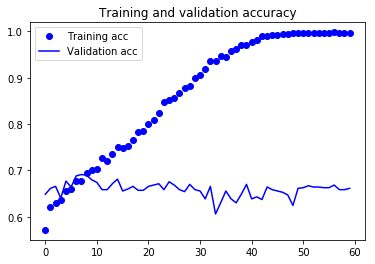

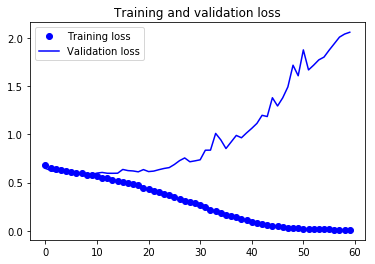

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Validate model

In [10]:
samuel_images_test_dir = 'data/samuel_images_test'

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        samuel_images_test_dir,
        target_size=(200, 300),
        batch_size=20,
        class_mode='binary')

Found 336 images belonging to 2 classes.


In [12]:
loss, acc = model.evaluate_generator(test_generator)
print('loss={}, acc={}'.format(loss, acc))

loss=2.7343464436985196, acc=0.6071428539497512


### Display predicted items

In [13]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [14]:
predictions = model.predict_generator(test_generator)

In [15]:
test_image_results = pd.DataFrame({
    'prediction': predictions.flatten(),
    'filename': test_generator.filenames
}) \
.sort_values('prediction', ascending=False) \
.head(n=10)

In [16]:
test_image_results

,filename,prediction
0,notSamuel/1018.jpg,1.0
234,samuel/00000078.jpg,1.0
210,samuel/00000046.jpg,1.0
219,samuel/00000058.jpg,1.0
95,notSamuel/752.jpg,1.0
27,notSamuel/581.jpg,1.0
92,notSamuel/74.jpg,1.0
10,notSamuel/1125.jpg,1.0
31,notSamuel/587.jpg,1.0
172,samuel/00000003.jpg,1.0


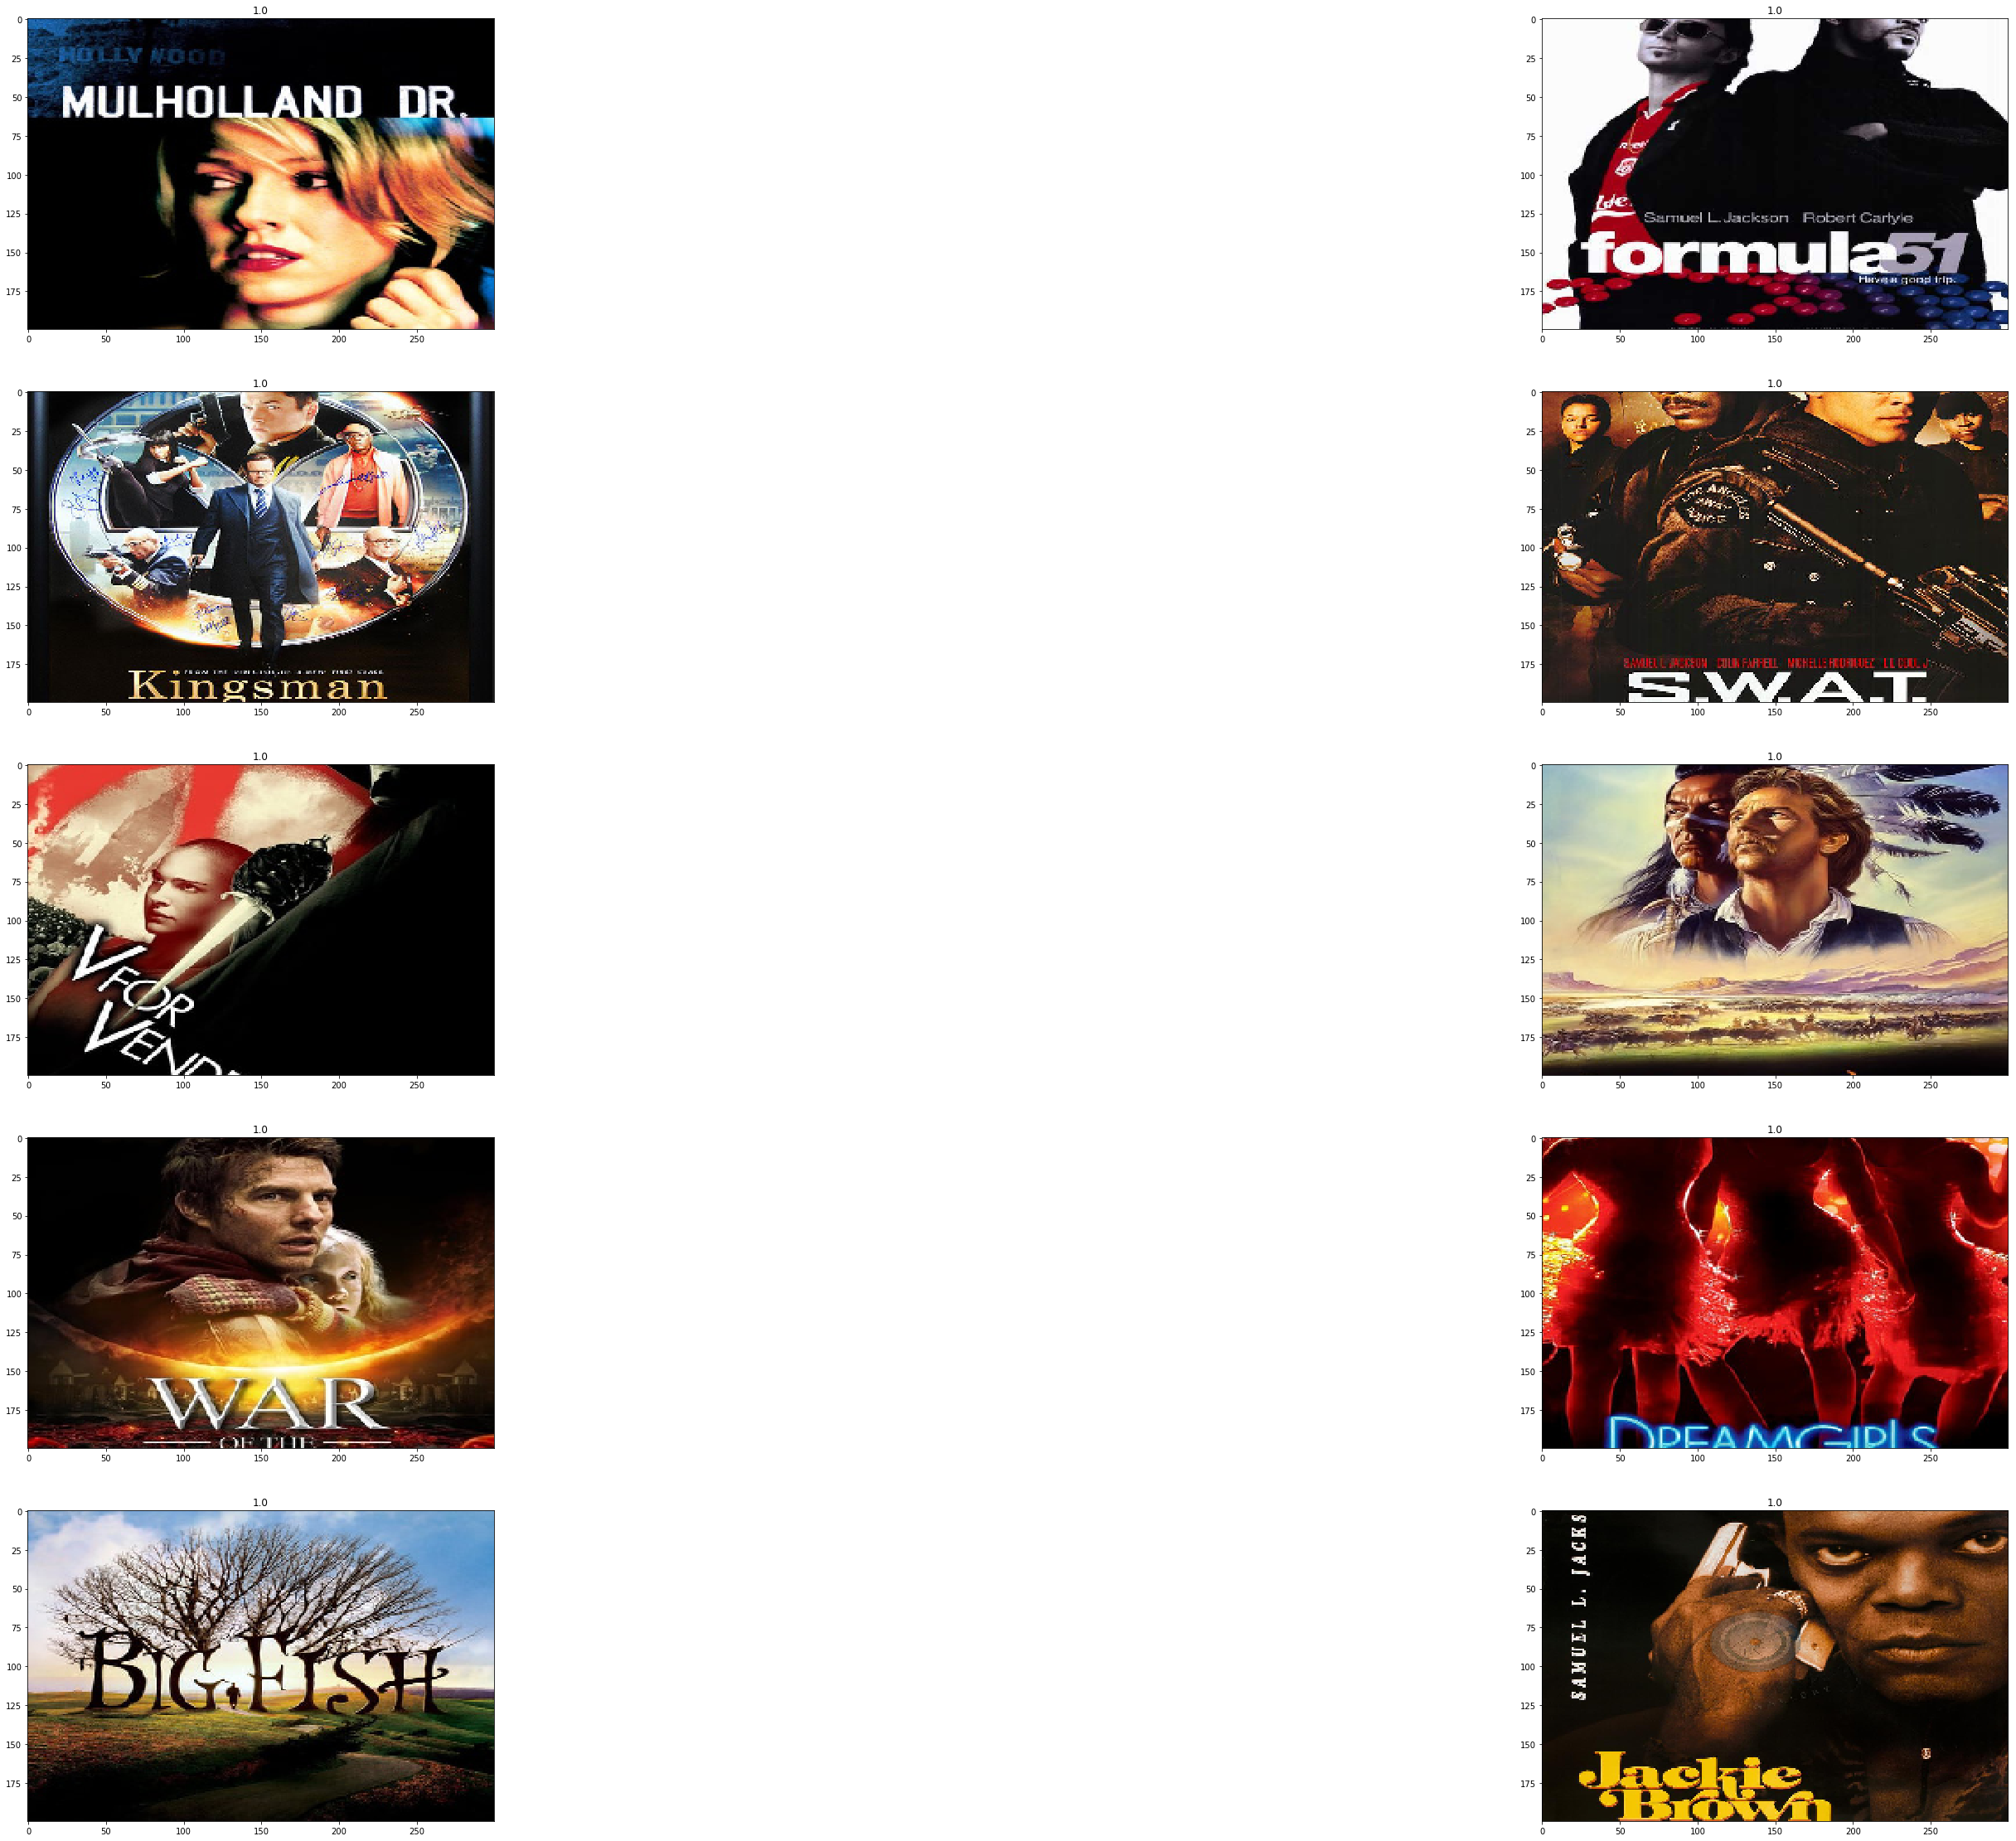

In [17]:
fnames = [os.path.join(samuel_images_test_dir, fname) for fname in test_image_results.filename]

imgs = [image.load_img(fname, target_size=(200,300)) for fname in fnames]
show_images(imgs, 5, test_image_results.prediction)

In [18]:
# Use Grid Search to use all cores https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
